<a href="https://colab.research.google.com/github/OlehKSS/cad-project/blob/master/Mole_classification_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mole Classification

In [0]:
import io
import os


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [0]:
tf.test.is_gpu_available()

True

In [0]:
tf.__version__

'1.12.0'

## Google Drive

In [0]:
# login to drive
from google.colab import auth
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from googleapiclient.discovery import build


auth.authenticate_user()

drive_service = build('drive', 'v3')

In [0]:
# helper functions
def get_file(file_id, file_name):
  '''Get a file from GoogleDrive.'''
  request = drive_service.files().get_media(fileId=file_id)
  #downloaded = io.BytesIO()
  downloaded = io.FileIO(file_name, 'wb')
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    status, done = downloader.next_chunk()
     
    perc = int(100 * status.progress())
    print('\r[%s%s]' % ('=' * perc, ' ' * (50 - perc)))
  
  #downloaded.seek(0)
  #print(os.fstat(downloaded.fileno()).st_size)
  downloaded.flush()
  os.fsync(downloaded)
  downloaded.close()
  print('File has been downloaded successfully!')
  
  #return downloaded
  
  
def save_file_to_drive(name, path):
  """Save a file to GoogleDrive."""
  file_metadata = {'name': name, 'mimeType': 'application/octet-stream'}

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  return created


def unzip_tar(file_path, out_path):
  """
  Unzip tar.gz files.
  
  Args:
    file_path (str): path to the file to unzip.
    out_path (str): output path.
  """
  import tarfile
  
  tar = tarfile.open(file_path, "r:gz")
  tar.extractall(out_path)
  tar.close()
  

def val_test_split(val_path, test_path, split=0.5):
  """
  Split our validation data into validation/test sets.
  
  Args:
    val_path (str): validation data path.
    test_path (str): path where test files will be copied.
    spit (float): split ratio, e.g. if split=0.3, it means that 30% of images 
      from validation set  will be moved to test set.
  """
  from shutil import move
  from os import listdir
  from os.path import isdir, join
  from random import sample
  
  onlydirs = tuple(f for f in listdir(val_path) if isdir(join(val_path, f)))
  
  os.mkdir(test_path)
  
  for dir in onlydirs:
    os.mkdir(join(test_path, dir))
    files = tuple(f for f in listdir(join(val_path, dir)) if not isdir(join(val_path, dir, f)))
    # number of files to choose
    k = int(split * len(files))
    
    files_to_move = sample(files, k)
    
    for file in files_to_move:
      move(join(val_path, dir, file), join(test_path, dir))
  
  
def plot_history(history):
    """Plots training history of the Keras model."""
    hist = history.history

    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '*-', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, '*-', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## Get Data

In [0]:
# CAD challenge 1, simple classification
train_data_id = '1AntSN4wcQ5x48wYXKnXJRzksPZYagQIr'
val_data_id = '14WHiW3wfjKKSbqXExzuWzxWwj-mVlA-F'

train_file_name = 'train.tar.gz'
val_data_name = 'val.tar.gz'

get_file(train_data_id, train_file_name)
get_file(val_data_id, val_data_name)

[=======                                           ]
[===============                                   ]
[=======================                           ]
[===============================                   ]
[=======================================           ]
[===============================================   ]
[=======================================================]
[==============================================================]
[======================================================================]
[==============================================================================]
[======================================================================================]
[==============================================================================================]
[====================================================================================================]
File has been downloaded successfully!
[===============================                   ]
[=======================

In [0]:
#! rm -rf data
# !unzip ./data.zip

train_path = './train'
val_path = './val'
test_path = './test'

# since archive contains a folder already
unzip_tar(train_file_name, './')
unzip_tar(val_data_name, './')
val_test_split(val_path, test_path)


## Prepa Data Generator

In [0]:
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn.metrics import classification_report, confusion_matrix

In [0]:
input_img_shape = (600, 450, 3)
no_epochs = 40
steps_per_epoch = 100
validation_steps = 50

In [0]:
# with data augentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                  zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# without data augmentation
# train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_path, target_size=input_img_shape[:2],
                                              batch_size=10, class_mode='binary')
validation_gen = test_datagen.flow_from_directory(val_path, target_size=input_img_shape[:2],
                                              batch_size=10, class_mode='binary')

test_gen = test_datagen.flow_from_directory(test_path,
                                            target_size=input_img_shape[:2],
                                            batch_size=10,
                                            #class_mode=None,
                                            shuffle=False)

train_gen.class_indices

Found 4800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


{'les': 0, 'nv': 1}

## Baseline for VGG16

In [0]:
conv_base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_img_shape)
#conv_base = Xception(weights='imagenet', include_top=False, input_shape=input_img_shape)

conv_base_vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600, 450, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 450, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 450, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 225, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 225, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 225, 128)     147584    
_________________________________________________________________
block2_pool

In [0]:
# densely connected classifier on top of the convolutional base
model_vgg16 = models.Sequential()
model_vgg16.add(conv_base_vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.BatchNormalization())
model_vgg16.add(layers.Dense(256, activation='relu'))
model_vgg16.add(layers.BatchNormalization())
model_vgg16.add(layers.Dense(1, activation='sigmoid'))

# freeze convolutional base
conv_base_vgg16.trainable = False

model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 18, 14, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 129024)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 129024)            516096    
_________________________________________________________________
dense (Dense)                (None, 256)               33030400  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 48,262,465
Trainable params: 33,289,217
Non-trainable params: 14,973,248
_______________________________________________________

In [0]:
model_vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history_vgg16 = model_vgg16.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=no_epochs, validation_data=validation_gen,
                              validation_steps=validation_steps)

Epoch 1/40
100/100 [==============================] - 144s 1s/step - loss: 0.7877 - acc: 0.6850 - val_loss: 0.7620 - val_acc: 0.5120
Epoch 2/40
100/100 [==============================] - 121s 1s/step - loss: 0.6563 - acc: 0.7310 - val_loss: 0.5870 - val_acc: 0.7000
Epoch 3/40
100/100 [==============================] - 115s 1s/step - loss: 0.6097 - acc: 0.7380 - val_loss: 0.5717 - val_acc: 0.7220
Epoch 4/40
100/100 [==============================] - 115s 1s/step - loss: 0.5622 - acc: 0.7510 - val_loss: 0.5948 - val_acc: 0.7580
Epoch 5/40
100/100 [==============================] - 118s 1s/step - loss: 0.5957 - acc: 0.7350 - val_loss: 0.6018 - val_acc: 0.7400
Epoch 6/40
100/100 [==============================] - 118s 1s/step - loss: 0.5540 - acc: 0.7460 - val_loss: 0.5842 - val_acc: 0.7680
Epoch 7/40
100/100 [==============================] - 118s 1s/step - loss: 0.5361 - acc: 0.7610 - val_loss: 0.5820 - val_acc: 0.7680
Epoch 8/40
100/100 [==============================] - 120s 1s/step - 

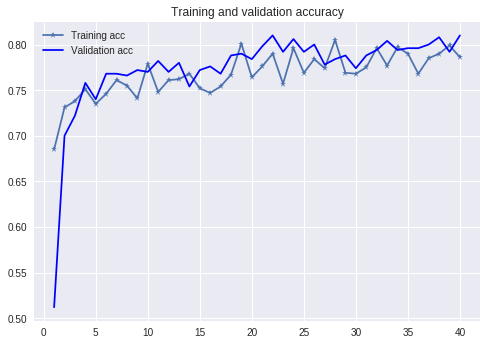

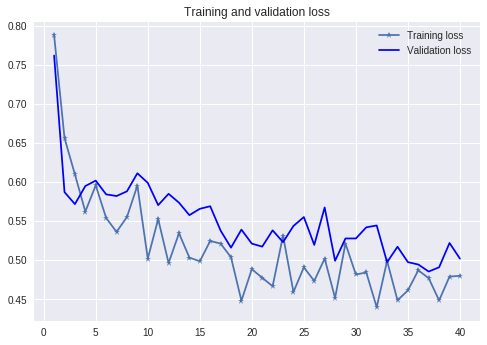

Confusion Matrix
[[250  50]
 [ 61 239]]
Classification Report
              precision    recall  f1-score   support

         les       0.80      0.83      0.82       300
          nv       0.83      0.80      0.81       300

   micro avg       0.81      0.81      0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600



In [0]:
# test the trained network
plot_history(history_vgg16)

# test_loss, test_acc = model_vgg16.evaluate_generator(test_gen, steps=50)
# print('test acc:', test_acc)


Y_pred = model_vgg16.predict_classes(test_gen)
y_pred = [p[0] for p in Y_pred]

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))

print('Classification Report')
target_names = ['les', 'nv']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

In [0]:
path_model = 'vgg16_baseline_e40.h5'
drive_name = 'vgg16_baseline_e40.h5'
#models.save_model(model, path_model)
# Save entire model to a HDF5 file
model.save(path_model)

save_file_to_drive(drive_name, path_model)

{'id': '10LDLWpsIgTQprqzHNWm07enqtk3hReZj'}

## Xception with Data Augmentation

In [0]:
conv_base_xc = Xception(weights='imagenet', include_top=False, input_shape=input_img_shape)

conv_base_xc.summary()

83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________

In [0]:
# densely connected classifier on top of the convolutional base
model_xc = models.Sequential()
model_xc.add(conv_base_xc)
model_xc.add(layers.Flatten())
model_xc.add(layers.Dense(256, activation='relu'))
model_xc.add(layers.Dense(1, activation='sigmoid'))

# freeze convolutional base
conv_base_xc.trainable = False

model_xc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 71680)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               18350336  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 39,212,073
Trainable params: 18,350,593
Non-trainable params: 20,861,480
_________________________________________________________________


In [0]:
model_xc.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history_xc = model_xc.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=no_epochs, validation_data=validation_gen,
                              validation_steps=validation_steps)

Epoch 1/40
100/100 [==============================] - 55s 554ms/step - loss: 0.5799 - acc: 0.7195 - val_loss: 0.6633 - val_acc: 0.6410
Epoch 2/40
100/100 [==============================] - 49s 487ms/step - loss: 0.5232 - acc: 0.7660 - val_loss: 0.5126 - val_acc: 0.7780
Epoch 3/40
100/100 [==============================] - 49s 487ms/step - loss: 0.4955 - acc: 0.7585 - val_loss: 0.4749 - val_acc: 0.7680
Epoch 4/40
100/100 [==============================] - 49s 490ms/step - loss: 0.5039 - acc: 0.7590 - val_loss: 0.4692 - val_acc: 0.7790
Epoch 5/40
100/100 [==============================] - 49s 487ms/step - loss: 0.4646 - acc: 0.7810 - val_loss: 0.4843 - val_acc: 0.7640
Epoch 6/40
100/100 [==============================] - 49s 486ms/step - loss: 0.5089 - acc: 0.7715 - val_loss: 0.4319 - val_acc: 0.7960
Epoch 7/40
100/100 [==============================] - 49s 488ms/step - loss: 0.4569 - acc: 0.7980 - val_loss: 0.4336 - val_acc: 0.7930
Epoch 8/40
100/100 [==============================] - 4

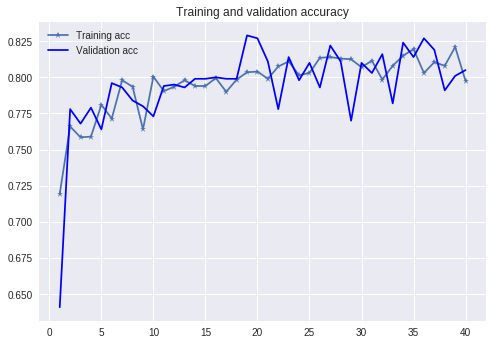

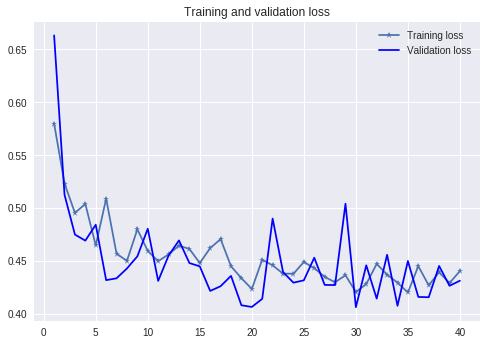

Confusion Matrix
[[258  42]
 [ 70 230]]
Classification Report
              precision    recall  f1-score   support

         les       0.79      0.86      0.82       300
          nv       0.85      0.77      0.80       300

   micro avg       0.81      0.81      0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600



In [0]:
# test the trained network
plot_history(history_xc)

# test_loss, test_acc = model_vgg16.evaluate_generator(test_gen, steps=50)
# print('test acc:', test_acc)


Y_pred = model_xc.predict_classes(test_gen)
y_pred = [p[0] for p in Y_pred]

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))

print('Classification Report')
target_names = ['les', 'nv']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

In [0]:
path_model = 'xception_baseline_e40.h5'
drive_name = 'xception_baseline_e40.h5'
#models.save_model(model, path_model)
# Save entire model to a HDF5 file
model.save(path_model)

save_file_to_drive(drive_name, path_model)

{'id': '1CsNcyRxdhSlkBAPNJ9HQfR3BhMIBVl0m'}

In [0]:
# import tarfile
# tar = tarfile.open("test_300.tar.gz", "w:gz")
# tar.add(test_path, arcname="test_300")
# tar.close()

# save_file_to_drive("val_300.tar.gz", "val_300.tar.gz")
# save_file_to_drive("test_300.tar.gz", "test_300.tar.gz")

In [0]:
# test prediction of an image
# malignant
#img_path = './data/test/malignant/ISIC_0000030.jpg'
# benign
# img_path = './data/test/benign/ISIC_0000179.jpg'

# # fix naming!!!


# img = image.load_img(img_path, target_size=(150, 150))
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)
# img_tensor /= 255.

# pred = model.predict_classes(img_tensor)

# print(pred)